# Transformers Part 2 - Build a sentence completion model

The foundational Decoder only Transformer model (built on day 4) can now be enhanced into a powerful sentence completion model. What makes Transformers the Workhorse of Generative LLMs is not just their self-attention mechanism — it is the clever enhancements that turbocharge their learning.

The 4 key techniques:


> **1. Padding** - Adds "padding" tokens to make variable-length sequences (e.g., short and long sentences) the same size. Combined with masking, This enables batch processing, speeding up training on large corpus of datasets.

> **2. Multi Head attention** - Splits attention into multiple "heads" (e.g., 8), each focusing on different relationships in the sequence. What this essentially does is to learn the D-dimensional embeddings separately (D/number of heads) and combines them. Captures richer patterns—like connecting "cat" to "the" in one head and "sat" in another—making the model smarter and more nuanced.

> **3. Stacking Attention Blocks** - Multiple attention blocks (each multi headed) are stacked on to each other(e.g., 2-3), where each refines the previous layer’s understanding. This builds hierarchical understanding—from individual words to full sentence structure—crucial for tasks like completing "The cat sat on the..." with "mat.". Stacking builds deeper, smarter models.

> **4. Layer Normalization** - Normalizes the output of each sub-layer (attention and feed-forward) to stabilize training. It speeds up convergence and improves generalization, especially when stacking layers.

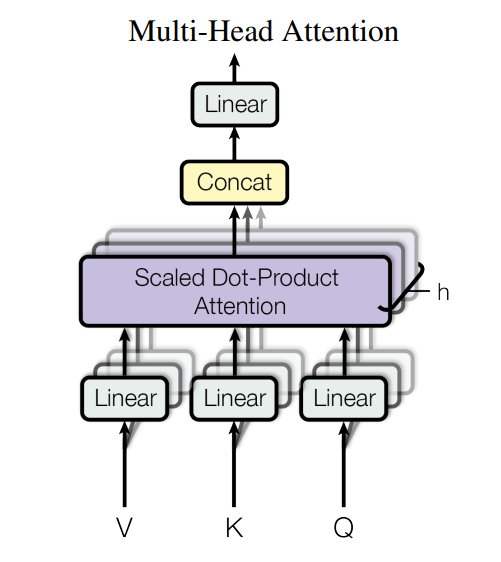

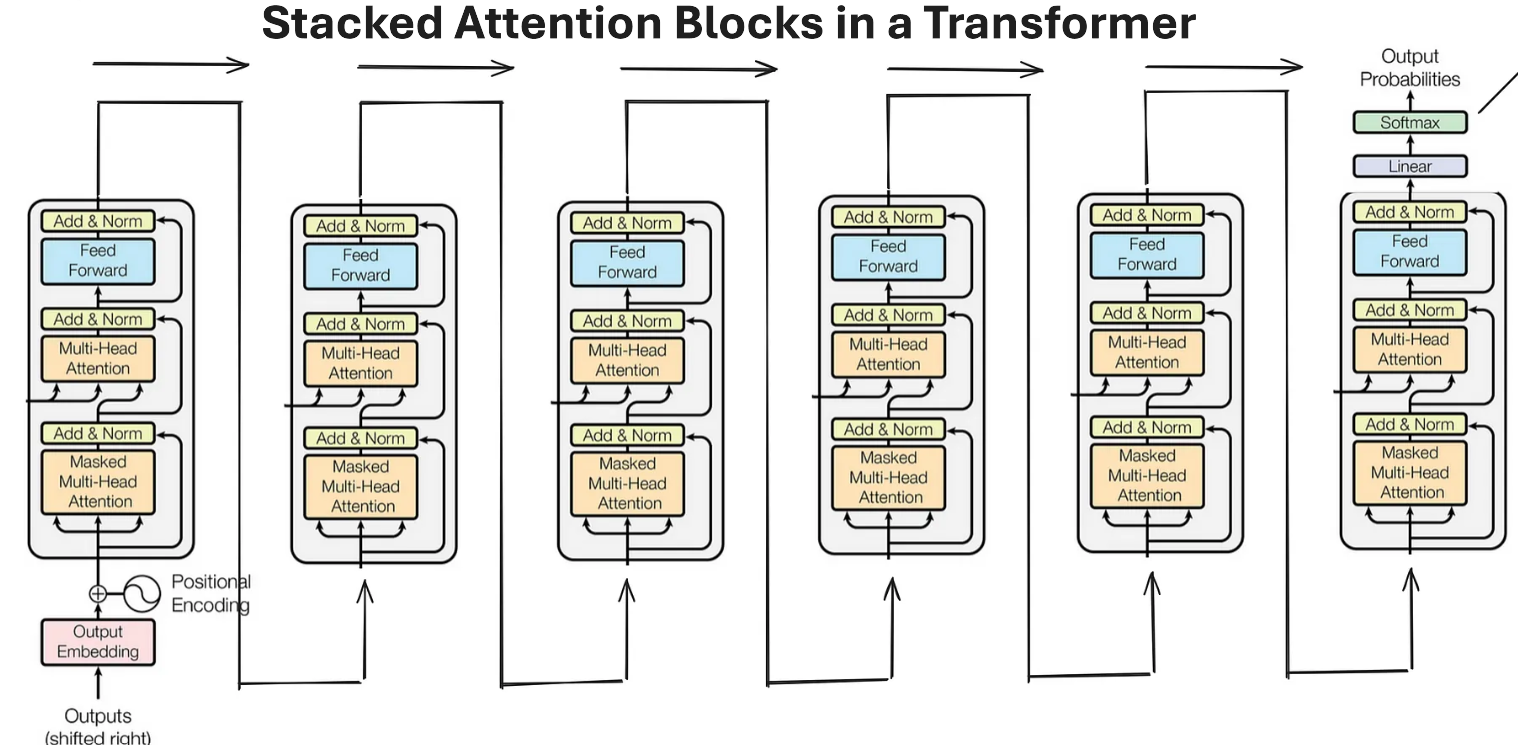

In [1]:
# Import relevant libraries

! pip install -q lightning

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import time
import warnings

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader

import lightning as L
# Ignore all warnings
warnings.filterwarnings("ignore")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 846.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.2/69.2 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 931.6/931.6 kB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.9/274.9 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.3/231.3 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 344.1/344.1 kB 19.1 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/torch_xla/__init__.py:253: UserWarning: `tensorflow` can conflict with `torch-xla`. Prefer `tensorflow-cpu` when using PyTorch/XLA. To silence this warning, `pip uninstall -y tensorflow && pip install tensorflow-cpu`. If you are in a notebook environment such as Colab or Kaggle, restart your notebook runtime afterwards.
  warnings.warn(


## Position encoding

In [2]:
class PositionEncoding(nn.Module):
    def __init__(self, d_model=2, max_len=6):
        super().__init__()
        pe = torch.zeros(max_len, d_model)

        # Precompute positional encodings
        position = torch.arange(max_len, dtype=torch.float).unsqueeze(1)  # [max_len, 1]
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float) * (-torch.log(torch.tensor(10000.0)) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        # Add batch dimension for broadcasting: [1, max_len, d_model]
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, word_embeddings):
        """
        Add positional encodings to batched word embeddings.
        Args:
            word_embeddings: [batch_size, seq_len, d_model]
        Returns:
            [batch_size, seq_len, d_model]
        """
        seq_len = word_embeddings.size(1)  # Get sequence length from dim 1
        # Slice pe to match seq_len: [1, seq_len, d_model]
        pe_slice = self.pe[:, :seq_len, :]
        # Broadcasting adds pe to each sequence in the batch
        return word_embeddings + pe_slice

## Multihead Attention Block

In [3]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model=2, num_heads=2):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads  # Dimension per head

        # Linear projections for queries, keys, values, and output
        self.W_q = nn.Linear(d_model, d_model, bias=False)
        self.W_k = nn.Linear(d_model, d_model, bias=False)
        self.W_v = nn.Linear(d_model, d_model, bias=False)
        self.W_o = nn.Linear(d_model, d_model, bias=False)

    def forward(self, encodings_for_q, encodings_for_k, encodings_for_v, mask=None):
        batch_size, seq_len, _ = encodings_for_q.shape  # Shape: [batch_size, seq_len, d_model]

        # Linear projections
        q = self.W_q(encodings_for_q)  # [batch_size, seq_len, d_model]
        k = self.W_k(encodings_for_k)  # [batch_size, seq_len, d_model]
        v = self.W_v(encodings_for_v)  # [batch_size, seq_len, d_model]

        # Split into heads: [batch_size, num_heads, seq_len, d_k]
        q = q.view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        k = k.view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        v = v.view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)

        # Compute attention scores: [batch_size, num_heads, seq_len, seq_len]
        sims = torch.matmul(q, k.transpose(-2, -1)) / (self.d_k ** 0.5)

        # Apply mask if provided
        if mask is not None:
            mask = mask.unsqueeze(1)  # [batch_size, 1, seq_len, seq_len] for broadcasting
            sims = sims.masked_fill(mask, -1e9)

        # Softmax to get attention weights
        attention_percents = F.softmax(sims, dim=-1)

        # Compute attention output: [batch_size, num_heads, seq_len, d_k]
        attention_output = torch.matmul(attention_percents, v)

        # Concatenate heads: [batch_size, seq_len, d_model]
        attention_output = attention_output.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)

        # Final linear projection: [batch_size, seq_len, d_model]
        output = self.W_o(attention_output)
        return output

## Decoder layer

In [4]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model=2, num_heads=2, d_ff=8, dropout=0.1):
        super().__init__()
        self.self_attention = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model)
        )
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x, mask=None):
        # Self-attention sub-layer
        attn_output = self.self_attention(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))  # Residual + norm

        # Feed-forward sub-layer
        ffn_output = self.ffn(x)
        x = self.norm2(x + self.dropout(ffn_output))  # Residual + norm
        return x

## Decoder Only Transformer - main class

In [5]:
class DecoderOnlyTransformer(L.LightningModule):
    def __init__(self, num_tokens=4, d_model=2, num_heads=2, num_layers=6, d_ff=8, max_len=6, dropout=0.1):
        super().__init__()
        L.seed_everything(seed=42)
        self.num_tokens = num_tokens
        self.d_model = d_model

        # Embedding and positional encoding
        self.we = nn.Embedding(num_embeddings=num_tokens, embedding_dim=d_model)
        self.pe = PositionEncoding(d_model=d_model, max_len=max_len)
        self.dropout = nn.Dropout(dropout)

        # Stack 6 decoder layers
        self.layers = nn.ModuleList([
            DecoderLayer(d_model=d_model, num_heads=num_heads, d_ff=d_ff, dropout=dropout)
            for _ in range(num_layers)
        ])

        # Output layer
        self.fc_layer = nn.Linear(d_model, num_tokens)
        self.loss = nn.CrossEntropyLoss(ignore_index=0)

    def forward(self, token_ids, attention_mask=None):
        batch_size, seq_len = token_ids.shape

        # Embeddings and positional encoding
        word_embeddings = self.we(token_ids)  # [batch_size, seq_len, d_model]
        x = self.pe(word_embeddings)
        x = self.dropout(x)

        # Create masks
        causal_mask = torch.tril(torch.ones(seq_len, seq_len)).to(token_ids.device) == 0
        causal_mask = causal_mask.unsqueeze(0).expand(batch_size, -1, -1)
        if attention_mask is None:
            padding_mask = (token_ids == 0).unsqueeze(1).expand(-1, seq_len, -1)
        else:
            padding_mask = (attention_mask == 0).unsqueeze(1).expand(-1, seq_len, -1)
        final_mask = causal_mask | padding_mask

        # Pass through 6 stacked layers
        for layer in self.layers:
            x = layer(x, mask=final_mask)  # [batch_size, seq_len, d_model]

        # Final output
        fc_layer_output = self.fc_layer(x)  # [batch_size, seq_len, num_tokens]
        return fc_layer_output

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.01)

    def training_step(self, batch, batch_idx):
        input_tokens, labels = batch
        output = self.forward(input_tokens)
        loss = self.loss(output.view(-1, self.num_tokens), labels.view(-1))
        self.log("train_loss", loss, prog_bar=True)
        return loss

## Get training data

In [6]:
! pip install -q datasets
! pip install -q contractions

from datasets import load_dataset
import nltk
import regex as re
from contractions import contractions_dict
import torch
import numpy as np
import pandas as pd
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader


# dataset = load_dataset("ccdv/cnn_dailymail", '3.0.0', trust_remote_code=True)
cnn_dataset = load_dataset("cnn_dailymail", "3.0.0")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 9.1 MB/s eta 0:00:00


README.md:   0%|          | 0.00/15.6k [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/259M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/34.7M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/30.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

In [7]:
def get_data_corpus(data, n):
  corp = ''
  for i in range(n):
    corp = corp + ' '+ data['train'][i]['article']
  return corp

# Get expanded contractions
def expand_contractions(text, contraction_map=contractions_dict):
    con_key = '|'.join(contraction_map.keys())
    cppp = re.compile(f'({con_key})', flags=re.DOTALL)

    def e_m(contraction):
        match = contraction.group(0)
        exp_c = contraction_map.get(match)
        if not expand_contractions:
            print(match)
            return match
        return exp_c

    text_e = cppp.sub(e_m, text)
    text_e = re.sub("'", "", text_e)
    return text_e

def get_clean_data(input_text):

  column_string = input_text #' '.join(dd['article'][0:250].tolist()) # Get rows to one big string

  column_string = expand_contractions(column_string)  # Expand contractions
  column_string = re.sub(r'-', ' ', column_string) # Replace hyphens with space

  column_string = re.sub("[^A-Za-z .]", "" , column_string) #re.sub("[^-9A-Za-z .]", "" , column_string) # Remove punctuations - in case we need to include more punctuations -> re.sub("[^a-zA-Z :\.]", "", line)
  # column_string = re.sub(r' ', '_', column_string) # Replace hyphens with space
  column_string = column_string.lower() # Convert to lowercase
  column_string = re.sub(r'\.', " . ", column_string) # Replace dot with space and dot
  column_string = re.sub(r'\.', "<EOS>", column_string) # Replace dot with <EOS> token
  column_string = re.sub("\s+"," ",column_string) # Remove extra spaces
  return column_string


# corpus = get_data_corpus(dataset, 2)

# Tokenization function (splitting by words and replacing "'" with <EOS>)
def tokenize_text(text):
    tokens = text.replace(".", " <EOS> ").split()  # Replace apostrophe and split
    unique_tokens = sorted(set(tokens))  # Get unique tokens sorted
    token_dict = {token: idx+1 for idx, token in enumerate(unique_tokens)}  # Assign token IDs
    return tokens, token_dict

# Apply tokenization and get dicts = token_to_id and id_to_token
def get_dicts(column_string):
  tokens, t_to_i = tokenize_text(column_string)
  i_to_t = {v:k for k,v in t_to_i.items()}
  return t_to_i, i_to_t




In [8]:
def prepare_inputs_labels_with_padding(data, t_to_i, n):
    inputs_list = []
    labels_list = []

    for i in range(n):
        current_article = get_clean_data(data['train'][i]['article'])

        for each in current_article.split('<EOS>'):
            tokens = each.split()
            current_inputs = [t_to_i.get(token, 0) for token in tokens]  # Default to 0 if unknown
            current_labels = current_inputs[1:] + [t_to_i['<EOS>']]  # Shift left for labels

            inputs_list.append(torch.tensor(current_inputs, dtype=torch.long))
            labels_list.append(torch.tensor(current_labels, dtype=torch.long))

    # Pad sequences to the same length
    inputs_padded = pad_sequence(inputs_list, batch_first=True, padding_value=0)
    labels_padded = pad_sequence(labels_list, batch_first=True, padding_value=0)

    return inputs_padded, labels_padded

## Get final data

In [53]:
n = 100
corpus = get_data_corpus(cnn_dataset, n)
# corpus = get_data_corpus(dataset, len(dataset['train']))
cleaned_corpus = get_clean_data(corpus)
token_to_id, id_to_token = get_dicts(cleaned_corpus)
token_to_id['<pad>'] = 0
id_to_token[0] = '<pad>'
len(token_to_id), len(id_to_token)

(8882, 8882)

In [54]:
a, b = prepare_inputs_labels_with_padding(cnn_dataset,token_to_id, n)
# dataset_new = TensorDataset(a,b)
# dataloader = DataLoader(dataset_new)
print(len(a), a.shape)
dataset_new = TensorDataset(a, b)
dataloader = DataLoader(dataset_new, batch_size=512, shuffle=True, pin_memory=True, num_workers=2)

3758 torch.Size([3758, 66])


# Build the decoder only model

In [55]:
model = DecoderOnlyTransformer(num_tokens= len(token_to_id), d_model = 32,num_heads=8, num_layers=2, d_ff=256, max_len = 100, dropout=0.1)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


In [56]:
# count the number of parameters in the model
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {num_params}")

Number of trainable parameters: 619122


## Train the model

In [57]:
# Ensure Google Drive is mounted
import os
from google.colab import drive
drive.mount('/content/drive')

save_loc_my_drive = "<your drive location>"

class SaveCheckpointCallback(L.Callback):
    def __init__(self, save_freq=2, save_dir=save_loc_my_drive):
        super().__init__()
        self.save_freq = save_freq
        self.save_dir = save_dir
        # Create directory if it doesn't exist
        os.makedirs(self.save_dir, exist_ok=True)
        # print(f"Initialized callback with save_dir: {self.save_dir}")

    def on_train_epoch_end(self, trainer, pl_module):
        epoch = trainer.current_epoch
        # print(f"Epoch {epoch + 1} ended")  # Debug to confirm callback is called
        if (epoch + 1) % self.save_freq == 0:
            # print("Now is the time to save the model")  # Debug save trigger
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': pl_module.state_dict(),
                'optimizer_state_dict': trainer.optimizers[0].state_dict(),
            }
            filename = f"{self.save_dir}/day_5_test_model_{epoch + 1}.pt"
            try:
                torch.save(checkpoint, filename)
                print(f"Saved checkpoint: {filename}")
            except Exception as e:
                print(f"Failed to save checkpoint: {e}")

# Training setup
checkpoint_callback = SaveCheckpointCallback(save_freq=25, save_dir=save_loc_my_drive)
trainer = L.Trainer(
    max_epochs=50,
    callbacks=[checkpoint_callback],
    accelerator="auto",
    devices=1,
    enable_progress_bar=True,
)
trainer.fit(model, train_dataloaders=dataloader)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: True, using: 1 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: True, using: 1 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | we       | Embedding        | 284 K  | train
1 | pe       | PositionEncoding | 0      | train
2 | dropout  | Dropout          | 0      | train
3 | layers   | ModuleList       | 41.8 K | train
4 | fc_layer | Linear           | 293 K  | train
5 | loss     | CrossEntropyLoss | 0      | train
------------------------------------------------------
619 K     Trainable params
0         Non-trainable params
619 K     Total params
2.476     Total estimated model params size (MB)
34        Modules in train mode
0         M

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Training: |          | 0/? [00:00<?, ?it/s]

Saved checkpoint: /content/drive/My Drive/Colab Notebooks/ML practice/Decoder_only_transformer_model_version_dumps/day_5_test_model_25.pt


INFO: `Trainer.fit` stopped: `max_epochs=50` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


Saved checkpoint: /content/drive/My Drive/Colab Notebooks/ML practice/Decoder_only_transformer_model_version_dumps/day_5_test_model_50.pt


## Model inference

In [34]:
def model_inference(model, prompt_index, token_to_id):
  model_input = torch.tensor(prompt_index) #, token_to_id["is"], token_to_id["where"]

  model_input = model_input.unsqueeze(0)  # Shape: [1, seq_len]
  input_length = model_input.size(dim=1)  # Now use dim=1 for seq_len
  predictions = model(model_input)

  predicted_id = torch.tensor([torch.argmax(predictions[0][-1,:])])
  predicted_ids = predicted_id

  max_length = 20

  for i in range(input_length, max_length):
    if predicted_id == token_to_id["<EOS>"]:
      break
    model_input = torch.cat((model_input, predicted_id.unsqueeze(0)), dim=1)
    predictions = model(model_input)
    predicted_id = torch.tensor([torch.argmax(predictions[0][-1,:])])
    predicted_ids = torch.cat((predicted_ids, predicted_id))
  return predicted_ids

In [60]:
# Prompt 1
prompt = "when i want to go"
prompt_index = [token_to_id[each] for each in prompt.split()] #+ [token_to_id["<EOS>"]] # Adding EOS token at the end as a default
# print(prompt_index)

model_result =model_inference(model, prompt_index, token_to_id)
print("Prompt:", prompt)
print("Model Response:", ' '.join([id_to_token[each.item()] for each in model_result]))


Prompt: when i want to go
Model Response: off the entryway you will be done <EOS>


In [97]:
# Prompt 2
prompt = "i think this will be a great way to be"
prompt_index = [token_to_id[each] for each in prompt.split()] #+ [token_to_id["<EOS>"]] # Adding EOS token at the end as a default

model_result =model_inference(model, prompt_index, token_to_id)
print("Prompt:", prompt)
print("Model Response:", ' '.join([id_to_token[each.item()] for each in model_result]))


Prompt: i think this will be a great way to be
Model Response: a strong guy to survive <EOS>
